In [4]:
# pip install wget
!python -m wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz


Saved under images.tar.gz


In [5]:
!python -m wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


Saved under annotations.tar.gz


In [6]:
!tar -xf images.tar.gz

In [7]:
!tar -xf annotations.tar.gz

In [8]:
import os
input_dir = "images/"
target_dir = "annotations/trimaps/"

In [9]:
input_img_paths = sorted(
    [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])

In [10]:
target_paths = sorted(
    [os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

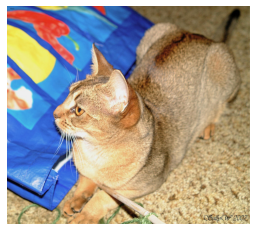

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

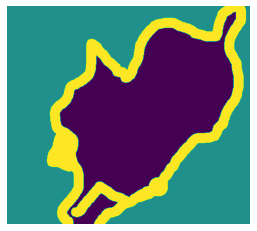

In [12]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:,:, 0])
    
img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [15]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

In [16]:
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

In [17]:
def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

In [18]:
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

In [19]:
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)
    
    x = layers.Conv2D(64, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, activation="relu", padding='same')(x)
    x = layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation='relu')(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    
    x = layers.Conv2DTranspose(256, 3, activation='relu', padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same', strides=2)(x)
    
    outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)
    
    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 64)      1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_10 (Conv2D)          (None, 25, 25, 256)       295168

In [22]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]
history = model.fit(train_input_imgs, train_targets,
                   epochs=50, callbacks=callbacks, batch_size=64, validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - 552s 6s/step - loss: 3.5581 - val_loss: 0.9004
Epoch 2/50
100/100 [==============================] - 554s 6s/step - loss: 0.9120 - val_loss: 0.8410
Epoch 3/50
100/100 [==============================] - 563s 6s/step - loss: 0.8320 - val_loss: 0.7611
Epoch 4/50
100/100 [==============================] - 570s 6s/step - loss: 0.8038 - val_loss: 0.7593
Epoch 5/50
100/100 [==============================] - 566s 6s/step - loss: 0.7553 - val_loss: 0.8001
Epoch 6/50
100/100 [==============================] - 570s 6s/step - loss: 0.7067 - val_loss: 0.7870
Epoch 7/50
100/100 [==============================] - 565s 6s/step - loss: 0.6606 - val_loss: 0.6304
Epoch 8/50
100/100 [==============================] - 600s 6s/step - loss: 0.6271 - val_loss: 0.5646
Epoch 9/50
100/100 [==============================] - 606s 6s/step - loss: 0.6049 - val_loss: 0.5742
Epoch 10/50
100/100 [==============================] - 577s 6s/step - loss: 0.5744 - val_lo

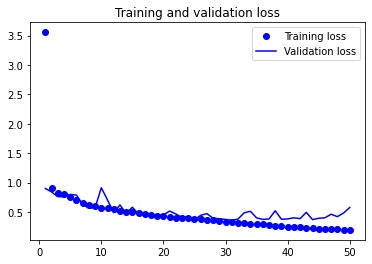

In [23]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

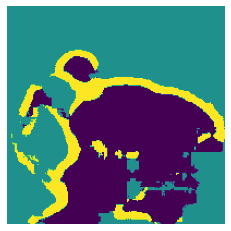

In [24]:
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]
def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)
    
display_mask(mask)

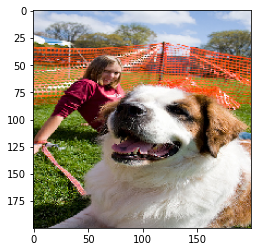

In [25]:
plt.imshow(array_to_img(test_image))